In [60]:
# Mogą byc błedy, kod pisany z palca

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import re
import os
import tensorflow as tf 

%load_ext autoreload
%autoreload 2
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
%matplotlib inline

config = tf.ConfigProto()

In [2]:
config.gpu_options.per_process_gpu_memory_fraction = 0.0
# config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
import ipywidgets as widgets
from ipywidgets import interact
import pickle

## Dataset

In [3]:
from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator

# The data, shuffled and split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
num_classes = 10
# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

Using TensorFlow backend.


x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [17]:
from collections import Counter
import matplotlib.mlab as mlab

matplotlib.rcParams.update({'font.size': 20})

def compute_statistics(y_pred):    
    x_c = np.array(list(map(lambda t: (t[1], t[0]), zip(*np.histogram(y_pred, 70, normed=True)))))    
    mu = y_pred.mean()
    sigma = y_pred.std()
    x = np.linspace(-3, 3, 100)    
    gauss = mlab.normpdf(x, mu, sigma)    
    return {"hist": x_c, "gauss": [x, gauss]}


def plot_stats(lo_stat_data, la_stat_data):     
    x_c = lo_stat_data["hist"]    
    plt.plot(x_c[:, 0], x_c[:, 1], '-', lw=2,  label="hist (before activation)")
    plt.ylim([0, 1.2*np.max(x_c[:, 1])])    
    x_c = la_stat_data["hist"]    
    plt.plot(x_c[:, 0], x_c[:, 1], 'r--', lw=1, label="hist (after activation)")    
    plt.legend(loc=1)


def append_history(fc_pred_history, fc_pred):
    for i in range(len(fc_pred)):
        stat_data = compute_statistics(fc_pred[i])
        fc_pred_history[i].append(stat_data)    

def get_history_at(fc_pred_history, batch):
    stats = []
    for i in range(len(fc_pred_history)):
        stats.append(fc_pred_history[i][batch])
    return stats

def plot_history_at(fc_pred_history, batch):
    stat_data = get_history_at(fc_pred_history, batch)
    num_plots = len(stat_data)//2
    plt.figure(figsize=(15, 15))
    for i in range(num_plots):
        plt.subplot(2, num_plots//2, i + 1)
        plt.title(f"fc{i+1}")
        plot_stats(stat_data[i], stat_data[num_plots + i])
    plt.show()
    
def plot_interactive(fc_pred_history):
    def draw(batch):
        plot_history_at(fc_pred_history, batch)
        plt.show()

    n = len(fc_pred_history[0]) - 1
    interact(draw, batch=widgets.IntSlider(min=0, max=n, step=1, value=n))
    
def plot_loss_history(loss_history_tuple):
    def running_mean(x, N=100):
        cumsum = np.cumsum(np.insert(x, 0, 0)) 
        return (cumsum[N:] - cumsum[:-N]) / N 
            
    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    plt.title("loss")
    
    params, loss_history = loss_history_tuple    
    plt.plot(running_mean(np.array(loss_history)[:, 0]), label=params['name'])
    
    plt.subplot(122)
    plt.title("acc")
    
    params, loss_history = loss_history_tuple
    plt.plot(running_mean(np.array(loss_history)[:, 1]), label=params['name'])
    
    plt.legend()
    plt.show()   

from keras.models import Model
from keras.layers import Dense, Convolution2D


def svd_orthonormal(shape):
    if len(shape) < 2:
        raise RuntimeError("Only shapes of length 2 or more are supported.")
    # flat_shape = (shape[0], np.prod(shape[1:]))
    flat_shape = (np.prod(shape[:-1]), shape[-1])
    a = np.random.standard_normal(flat_shape)
    u, _, v = np.linalg.svd(a, full_matrices=False)
    q = u if u.shape == flat_shape else v
    q = q.reshape(shape)
    return q


def get_activations(model, layer, batch_generator, steps):
    intermediate_layer_model = Model(inputs=model.get_input_at(0), outputs=layer.get_output_at(0))
    activations = intermediate_layer_model.predict_generator(batch_generator, steps=steps)
    return activations


def LSUVinit(model, batch_generator, steps, selu_init=False):
    # only these layer classes considered for 
    # LSUV initialization; add more if needed
    classes_to_consider = (Dense, Convolution2D)

    margin = 0.01
    max_iter = 10
    layers_inintialized = 0
    for layer in model.layers:
        print(layer.name)
        if not any([type(layer) is class_name for class_name in classes_to_consider]):
            continue
        # avoid small layers where activation variance close to zero, esp. for small batches
        if np.prod(layer.get_output_shape_at(0)[1:]) < 32:
            print(layer.name, 'too small')
            continue
        print('LSUV initializing', layer.name)
        layers_inintialized += 1
        w_all = layer.get_weights()
        weights = np.array(w_all[0])
        weights = svd_orthonormal(weights.shape)
        biases = np.array(w_all[1])
        w_all_new = [weights, biases]
        layer.set_weights(w_all_new)
        acts1 = get_activations(model, layer, batch_generator, steps)
        var1 = np.var(acts1)
        iter1 = 0
        needed_variance = 1.0
        print(var1)

        while abs(needed_variance - var1) > margin:
            w_all = layer.get_weights()
            weights = np.array(w_all[0])
            biases = np.array(w_all[1])
            if np.abs(np.sqrt(var1)) < 1e-7:
                break  # avoid zero division
            weights /= np.sqrt(var1) / np.sqrt(needed_variance)
            w_all_new = [weights, biases]
            layer.set_weights(w_all_new)
            acts1 = get_activations(model, layer, batch_generator, steps)
            var1 = np.var(acts1)
            iter1 += 1
            print(var1)
            if iter1 > max_iter:
                break
                
        if type(layer) == Dense and selu_init:
            # Normalize Dense layer to have w=0 and tau=1
            w_all = layer.get_weights()
            weights = np.array(w_all[0])
            weights = weights - weights.mean(0)
            weights = weights/np.sqrt((weights**2).sum(0))

            biases = np.array(w_all[1])*0
            w_all_new = [weights, biases]
            layer.set_weights(w_all_new)
            print(weights.shape)
            print("w:", (weights).sum(0))
            print("tau:", (weights**2).sum(0))                
    print('LSUV: total layers initialized', layers_inintialized)
    return model


import keras.backend as K

def selu(x):
    """Scaled Exponential Linear Unit. (Klambauer et al., 2017)
    # Arguments
        x: A tensor or variable to compute the activation function for.
    # References
        - [Self-Normalizing Neural Networks](https://arxiv.org/abs/1706.02515)
    """
    alpha = 1.6732632423543772848170429916717
    scale = 1.0507009873554804934193349852946
    return scale * K.elu(x, alpha)


def prelu(name):
    prelu = keras.layers.advanced_activations.PReLU(alpha_initializer='zeros', name=name)
    return prelu

In [5]:
from os.path import join
batch_size = 64
num_classes = 10
num_batches = 50000
dataset_name = "cifar10"
model_type = "dense"
save_folder = "activations_history_data"

# Model

In [6]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.initializers import RandomNormal
from keras.regularizers import Regularizer
import keras.backend as K
from SeluRegularizer import SeluRegularizer

def batch_regularization(activations):
    
    x_mean = K.mean(activations, axis=0)
    x_var = K.var(activations, axis=0)
    x_log_var = x_var - (1.0 + K.log(x_var + K.epsilon()))
    
    mean_loss = K.mean(K.square(x_mean))
    var_loss = K.mean(x_log_var)
    loss = 0.5*(mean_loss + var_loss)
    return 0.001*loss


from keras import activations
from keras import initializers
from keras import regularizers
from keras import constraints
from keras.engine import InputSpec
from keras.engine import Layer

class LetsDense(Dense):    
    def __init__(self, units,
                 activation=None,
                 use_bias=True,
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 bias_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None,
                 bias_constraint=None,
                 **kwargs):
        super(LetsDense, self).__init__(units, **kwargs)        
        self.activation = activations.get(activation)
        self.use_bias = use_bias
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.bias_initializer = initializers.get(bias_initializer)
        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)
        self.activity_regularizer = regularizers.get(activity_regularizer)
        self.kernel_constraint = constraints.get(kernel_constraint)
        self.bias_constraint = constraints.get(bias_constraint)
        self.input_spec = InputSpec(min_ndim=2)
        self.supports_masking = True
        

    def call(self, inputs):
        output = K.dot(inputs, self.kernel)        
        if self.activation is not None:
            output = self.activation(output)            
        if self.use_bias:
            output = K.bias_add(output, self.bias)            
        return output

In [9]:
def get_model(**params):
    
    activation = params.get("activation", 'linear')
    advanced_activation = params.get("advanced_activation", None)
    batch_norm = params.get("batch_norm", False)
    
    selu_init = params.get("selu_init", False)
    selu_reg = params.get("selu_reg", False)
    
    batch_reg = params.get("batch_reg", False)
    
    lets_dense = params.get("lets_dense", False)
    
    if not lets_dense:
        print("with Dense")
        dense_layer = Dense
    else:
        print("with Lets Dense")
        dense_layer = LetsDense
    
    num_layers = 4
    n_hidden = 256
    
    def get_init():
        if selu_init:            
            init_scale = 1
            init = RandomNormal(stddev=np.sqrt(init_scale/n_hidden))
            return init
        else:
            return 'glorot_uniform'
       
    def get_reg():
        if selu_reg:
            print("with selu Reg")
            return SeluRegularizer()
        else:
            return None
        
    def get_batch_reg():
        if batch_reg:
            print("with batch_reg")
            return batch_regularization
        else:
            return None
        
    
    
    model = Sequential()    
    model.add(Flatten(input_shape=x_train.shape[1:]))
    
    for l in range(1, num_layers+1):
        model.add(dense_layer(n_hidden, activity_regularizer=get_batch_reg(),
                        name=f"l{l}", 
                        kernel_initializer=get_init(), 
                        kernel_regularizer=get_reg()))
        if advanced_activation == None:
            model.add(Activation(activation, name=f"a{l}"))
        else:
            model.add(advanced_activation(name=f"a{l}"))
        if batch_norm:
            model.add(BatchNormalization())
        
    model.add(Dense(num_classes, kernel_initializer=get_init()))
    model.add(Activation('softmax'))
    
    opt = keras.optimizers.Adam(lr=0.002)
    
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['categorical_accuracy'])

    l_outputs = [model.get_layer(f"l{l}").output for l in range(1, num_layers+1)]
    a_outputs = [model.get_layer(f"a{l}").output for l in range(1, num_layers+1)]
    
    lo_model = Model(model.layers[0].input, l_outputs + a_outputs)
        
    return model, lo_model

In [10]:
# This will do preprocessing and realtime data augmentation:
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=5,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False)  # randomly flip images

In [11]:
def get_path(name):
    return join(save_folder, f"{dataset_name}_{model_type}_{name}")

In [12]:
def benchmark_model(name, **params):

    lsuv_init = params.get("lsuv_init", False)
    lsuv_selu_init = params.get("lsuv_selu_init", False)
    
    model, lo_model = get_model(**params)
        
    train_generator = datagen.flow(x_train, y_train, batch_size=batch_size)
    
    if lsuv_init:
        LSUVinit(model, train_generator, 5, selu_init=lsuv_selu_init)
        
    fc_pred_history = {i: [] for i in range(len(lo_model.outputs))}
    loss = 0
    loss_history = []
    for i in tqdm(range(num_batches)):
        x_batch, y_batch = next(train_generator)        
        if i%500 == 0:
            lo_pred = lo_model.predict_on_batch(x_batch)
            append_history(fc_pred_history, lo_pred)        
        loss = model.train_on_batch(x_batch, y_batch)
        loss_history.append(loss)

    plt.plot(np.array(loss_history)[:, 0])
    plt.show()
    test_evaluation = model.evaluate(x_test, y_test)
    print("Model evaluation:", test_evaluation)
    
    params["name"] = name
    save_path = get_path(name)
    
    model.save_weights(save_path+".h5")    
    with open(save_path+".yaml", 'w') as f:
        f.write(model.to_yaml())
    
    pickle.dump([fc_pred_history, 
                 loss_history, 
                 test_evaluation, 
                 params], open(save_path+".pkl", "wb"))

In [13]:
from keras.models import model_from_yaml, Sequential, model_from_json

def get_history_data(name):
    save_path = get_path(name)
    pkl_data = pickle.load(open(save_path+".pkl", "rb"))
    fc_pred_history, loss_history, test_evaluation, params = pkl_data
    return fc_pred_history, loss_history, test_evaluation, params

def load_model(name):
    save_path = get_path(name)    
    with open(save_path + ".yaml", 'r') as f:
        architecture = f.read()        
        model = model_from_yaml(architecture, custom_objects={
            'SeluRegularizer': SeluRegularizer
        })
    model.load_weights(save_path + ".h5")
    return model

In [58]:
# test_train_generator = datagen.flow(x_train, y_train, batch_size=batch_size)
# x_batch, y_batch = next(test_train_generator)
# m, a = get_model(selu_reg=False, lets_dense=False)
# m.summary()
# # a_pred = a.predict_on_batch(x_batch)

In [59]:
# params = {"activation" : 'relu', 'batch_reg': True}
# benchmark_model("test_model", **params)

# Train RELU

100%|██████████| 50000/50000 [20:16<00:00, 41.11it/s]


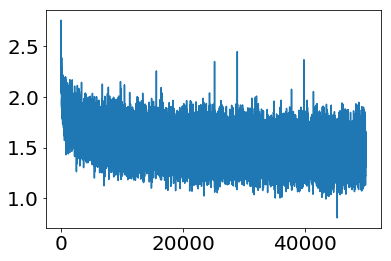

10000/10000 [==============================] - 0s     
Model evaluation: [1.4640458410263062, 0.48089999999999999]


In [106]:
params = {"activation" : 'relu'}
benchmark_model("hist@relu", **params)

In [42]:
name = "hist@relu"
fc_pred_history, loss_history, test_evaluation, params = get_history_data(name)

In [43]:
plot_interactive(fc_pred_history)

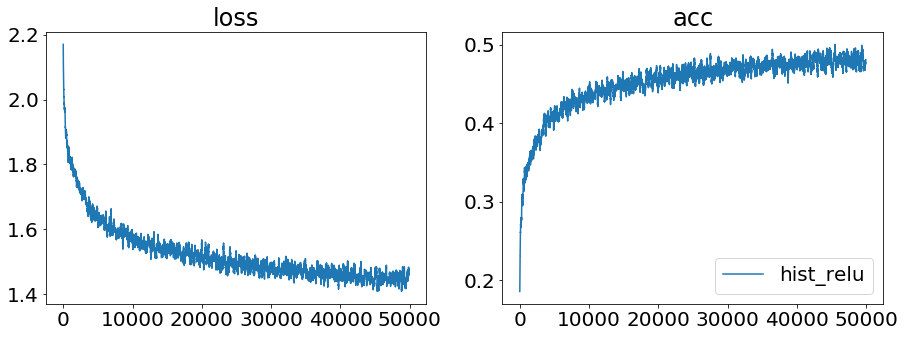

In [109]:
loss_history_tuple = (params, loss_history)
plot_loss_history(loss_history_tuple)

# Train selu with default initialization

100%|██████████| 50000/50000 [20:45<00:00, 40.15it/s]


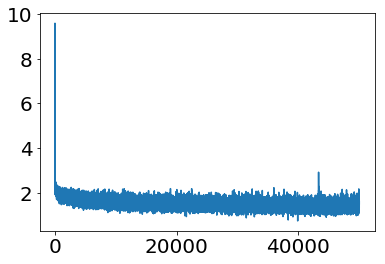

 9472/10000 [===========================>..] - ETA: 0sModel evaluation: [1.5151993719100951, 0.4546]


In [110]:
params = {"activation": selu, "selu_init": True}
benchmark_model("ist@selu", **params)

In [44]:
name = "hist@selu"
fc_pred_history, loss_history, test_evaluation, params = get_history_data(name)

In [45]:
plot_interactive(fc_pred_history)

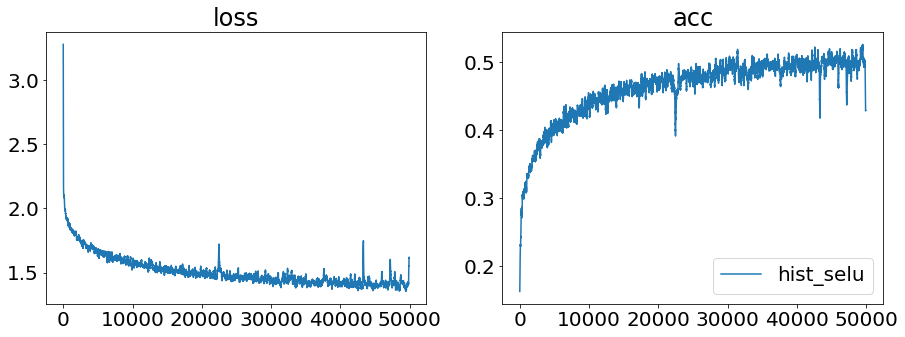

In [113]:
loss_history_tuple = (params, loss_history)
plot_loss_history(loss_history_tuple)

## Selu with LSUV initialization

flatten_22
l1
LSUV initializing l1
0.326263
0.993895
a1
l2
LSUV initializing l2
0.903343
0.969113
1.00102
a2
l3
LSUV initializing l3
1.05054
0.986328
1.03327
0.963676
0.97826
1.0524
0.981922
1.00883
a3
l4
LSUV initializing l4
0.959783
1.03326
0.973049


  0%|          | 0/50000 [00:00<?, ?it/s]

1.00692
a4
dense_21
dense_21 too small
activation_33
LSUV: total layers initialized 4


100%|██████████| 50000/50000 [20:20<00:00, 40.98it/s]


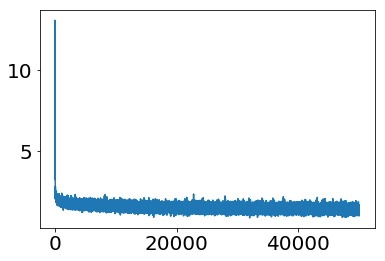

 9344/10000 [===========================>..] - ETA: 0sModel evaluation: [1.3583441442489623, 0.52759999999999996]


In [114]:
params = {"activation": selu, "lsuv_init": True}
benchmark_model("hist@selu@lsuv_init", **params)

In [273]:
name = "hist@selu@lsuv_init"
fc_pred_history, loss_history, test_evaluation, params = get_history_data(name)

In [274]:
plot_interactive(fc_pred_history)

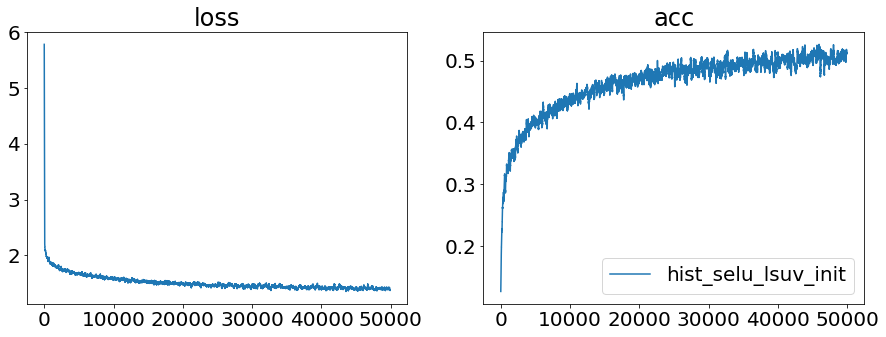

In [117]:
loss_history_tuple = (params, loss_history)
plot_loss_history(loss_history_tuple)

# Selu with LSUV initialization and SELU init fix

flatten_23
l1
LSUV initializing l1
0.29133
1.03572
0.947621
1.004
(3072, 256)
w: [  1.36345625e-06   1.33365393e-06   3.89385968e-06   7.78585672e-07
  -1.60216587e-07  -1.18836761e-06  -1.02818012e-06  -5.58793545e-08
  -4.26545739e-07  -1.22003257e-06  -4.08384949e-07   1.24238431e-06
  -1.65402889e-06   7.19912350e-07   4.82425094e-07  -1.97440386e-07
  -1.63074583e-06  -7.26431608e-07  -6.70552254e-08   7.27362931e-07
  -7.68341124e-08   7.62753189e-07   3.01748514e-07   1.27451494e-06
  -7.55302608e-07  -8.60542059e-07   1.30385160e-06  -1.61118805e-07
   2.26963311e-06  -1.22003257e-06  -4.55416739e-07   6.07920811e-07
  -2.80328095e-07   8.21892172e-08   6.07222319e-07  -1.83470547e-06
  -1.41561031e-07   5.75557351e-07   8.12811777e-07  -1.50990672e-06
   3.74857336e-08   8.75443220e-07  -4.12575901e-07  -2.45869160e-07
  -1.08964741e-06  -3.08617018e-07   1.01979822e-06   1.19488686e-06
   8.95932317e-07  -3.17580998e-07   7.09667802e-07  -7.25965947e-07
  -1.01514161e-06  -1.

0.117283
0.990049
(256, 256)
w: [  3.57627869e-07  -7.86967576e-07  -5.96046448e-08   2.75671482e-07
   7.07805157e-08  -4.76604328e-07   2.49594450e-07   2.01165676e-07
   1.56462193e-06   2.00816430e-07   5.65451046e-07   9.12696123e-08
  -1.52736902e-07   9.31322575e-07   3.76254320e-07   1.52736902e-07
   4.58210707e-07  -4.84287739e-08  -5.66244125e-07  -1.78813934e-07
  -1.15483999e-07   1.34110451e-07   7.26431608e-08   2.86847353e-07
   1.97440386e-07   3.35276127e-07   1.56462193e-07   1.71363354e-07
   2.44006515e-07  -2.90572643e-07  -9.97912139e-07  -2.08616257e-07
  -3.31550837e-07  -1.37835741e-07  -2.16066837e-07  -1.86264515e-07
  -8.94069672e-08  -9.17352736e-07   4.47034836e-08  -5.88595867e-07
   1.49011612e-08   2.90572643e-07   6.81728125e-07   2.16066837e-07
  -2.42143869e-08   7.07805157e-08   2.83122063e-07  -2.86847353e-07
  -2.49594450e-07  -8.64267349e-07   1.78813934e-07   8.94069672e-08
   6.10947609e-07   7.74860382e-07   4.37721610e-07  -1.50874257e-07
  

  0%|          | 0/50000 [00:00<?, ?it/s]

1.00729
(256, 256)
w: [  6.25848770e-07   3.72529030e-07   1.71363354e-07   2.04890966e-07
  -5.96046448e-08   1.78813934e-07  -1.86264515e-07   4.47034836e-07
  -3.72529030e-09  -3.01748514e-07  -4.17232513e-07  -5.64381480e-07
  -3.05473804e-07   1.34110451e-07  -6.14672899e-08   2.68220901e-07
  -1.53668225e-07  -2.75671482e-07   5.45755029e-07   4.15369868e-07
   7.37607479e-07   8.19563866e-08   2.30967999e-07   3.11061740e-07
  -6.44475222e-07   3.20374966e-07  -5.04776835e-07   8.94069672e-08
   2.08616257e-07   5.27128577e-07  -1.26659870e-07   0.00000000e+00
   1.16997398e-07  -4.54485416e-07  -1.71829015e-07   3.72529030e-08
   1.50874257e-07  -7.45058060e-09   2.04890966e-08  -2.73808837e-07
  -3.72529030e-08  -1.64844096e-07   4.13507223e-07   3.27825546e-07
  -7.07805157e-08   2.96160579e-07  -2.98023224e-07  -1.56462193e-07
   1.35507435e-07   1.71363354e-07   2.08616257e-07   7.45058060e-08
  -2.34693289e-07  -1.71363354e-07   9.79751348e-07   2.60770321e-07
  -1.9371509

100%|██████████| 50000/50000 [20:34<00:00, 40.91it/s]


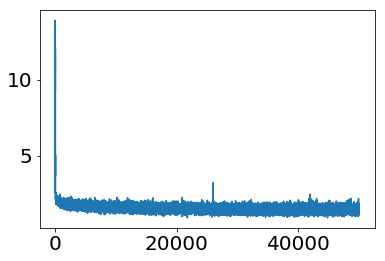

 9504/10000 [===========================>..] - ETA: 0sModel evaluation: [1.4379117599487306, 0.49220000000000003]


In [118]:
params = {"activation": selu, "lsuv_init": True, "lsuv_selu_init": True}
benchmark_model("hist@selu@lsuv_selu_init", **params)

In [46]:
name = "hist@selu@lsuv_selu_init"
fc_pred_history, loss_history, test_evaluation, params = get_history_data(name)

In [47]:
plot_interactive(fc_pred_history)

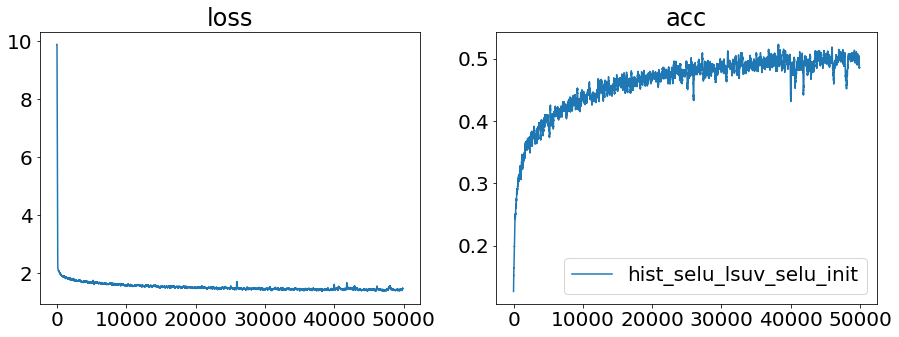

In [121]:
loss_history_tuple = (params, loss_history)
plot_loss_history(loss_history_tuple)

# Testing SELU activation with SELU regularization

  0%|          | 0/50000 [00:00<?, ?it/s]

with selu Reg
with selu Reg
with selu Reg
with selu Reg


100%|██████████| 50000/50000 [21:30<00:00, 38.75it/s]


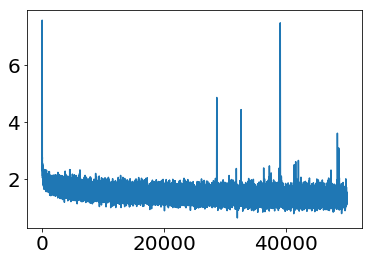

10000/10000 [==============================] - 1s     
Model evaluation: [1.3163322072982788, 0.56459999999999999]


In [168]:
params = {"activation": selu, "selu_init": True, "selu_reg": True}
benchmark_model("hist@selu@selu_init@selu_reg", **params)

In [48]:
name = "hist@selu@selu_init@selu_reg"
fc_pred_history, loss_history, test_evaluation, params = get_history_data(name)

In [49]:
plot_interactive(fc_pred_history)

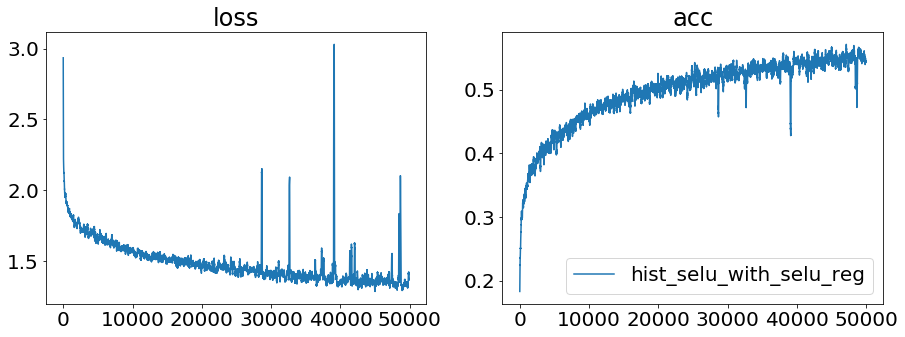

In [171]:
loss_history_tuple = (params, loss_history)
plot_loss_history(loss_history_tuple)

In [172]:
# load_model(name)

# Testing just ELU activation

flatten_33
l1
LSUV initializing l1
0.280528
1.03682
0.967255
1.02853
0.955631
1.04066
0.980954
1.02432
0.967747
1.0341
0.996624
(3072, 256)
w: [ -1.38767064e-06  -1.20699406e-06  -2.47359276e-06  -1.88872218e-06
   2.53319740e-07  -1.31130219e-06  -5.01982868e-07   7.02682883e-07
  -5.58793545e-07   1.71363354e-07   1.26659870e-07   5.73694706e-07
   2.13272870e-07  -1.12876296e-06   1.00582838e-06  -3.09012830e-06
  -9.63918865e-08   1.08405948e-06   4.19095159e-07  -4.50760126e-07
   8.52160156e-08  -2.57045031e-07  -8.52160156e-07  -2.14204192e-07
  -1.05332583e-06  -2.85916030e-07   2.48104334e-06   6.47269189e-07
   7.16187060e-07   6.17466867e-07  -8.77305865e-07   1.39599433e-06
  -4.55416739e-07  -7.26431608e-07  -6.90575689e-07  -1.70525163e-06
   1.83284283e-06  -9.33650881e-07  -7.01984391e-07   1.67381950e-06
  -7.10599124e-07   4.73111868e-07   2.55182385e-07  -1.09430403e-06
  -1.12131238e-06  -8.24220479e-08   8.52160156e-07  -9.31555405e-07
   8.85687768e-07  -1.8631108

0.0347632
0.997418
(256, 256)
w: [  1.13621354e-07   2.25380063e-07   2.42143869e-07  -1.11758709e-07
   2.49594450e-07  -1.21770427e-07   5.43892384e-07  -1.59721822e-07
  -1.15483999e-07   1.11758709e-07  -4.74974513e-07   5.15952706e-07
  -2.23517418e-07  -3.76254320e-07  -3.20374966e-07   7.35744834e-08
   1.56462193e-07  -3.35276127e-08   2.01165676e-07   4.91738319e-07
   2.66358256e-07  -2.28639692e-07   3.16649675e-07  -1.29395630e-07
  -2.67405994e-07  -2.40281224e-07   1.30617991e-07   1.50874257e-07
  -1.34110451e-06  -1.93715096e-07  -1.34110451e-07  -7.45058060e-08
   2.08616257e-07   4.02331352e-07  -4.63798642e-07   8.77305865e-07
   8.94069672e-08   7.63684511e-08   2.23517418e-07  -3.87430191e-07
   2.45869160e-07   2.98023224e-07   4.47034836e-08  -2.30967999e-07
   3.31550837e-07  -7.52508640e-07   1.49011612e-08   2.23517418e-07
  -4.06056643e-07  -6.29574060e-07  -9.68575478e-08  -1.93715096e-07
  -3.91155481e-08  -5.55068254e-07  -4.02331352e-07  -1.41561031e-07
 

  0%|          | 0/50000 [00:00<?, ?it/s]

0.996886
(256, 256)
w: [ -2.02096999e-07   1.52736902e-07  -2.04890966e-07  -1.22934580e-07
   2.01165676e-07  -9.87201929e-08   2.38418579e-07  -1.75088644e-07
  -2.34693289e-07  -1.15856528e-06   1.60187483e-07  -4.09781933e-07
   4.99188900e-07  -3.25497240e-07   6.92903996e-07   1.43423676e-07
   1.21071935e-07  -2.13272870e-07   5.96046448e-08  -3.20374966e-07
  -3.35276127e-08   1.76951289e-07  -9.31322575e-08   8.19563866e-08
   3.90224159e-07   4.09781933e-07   1.24797225e-06  -3.93018126e-07
   2.16066837e-07   1.19209290e-07  -5.32716513e-07   1.86264515e-07
   1.30385160e-07  -3.72529030e-09  -4.99188900e-07   3.27825546e-07
   4.84287739e-08   3.63215804e-08   9.20146704e-07   0.00000000e+00
   1.49011612e-07  -6.25848770e-07  -2.38418579e-07  -1.99303031e-07
   2.36555934e-07   1.89989805e-07  -2.92435288e-07   3.24100256e-07
  -2.23517418e-07   1.63912773e-07  -1.00582838e-07   0.00000000e+00
  -5.19677997e-07   3.57627869e-07  -2.03028321e-07   5.43892384e-07
  -2.852175

100%|██████████| 50000/50000 [20:03<00:00, 41.54it/s]


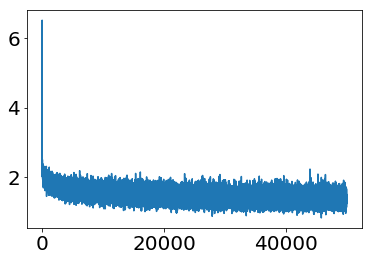

 9504/10000 [===========================>..] - ETA: 0sModel evaluation: [1.3807690145492553, 0.51229999999999998]


In [173]:
params = {"activation": "elu", "lsuv_init": True, "lsuv_selu_init": True}
benchmark_model("hist@elu@lsuv_selu_init", **params)

In [277]:
name = "hist@elu@lsuv_selu_init"
fc_pred_history, loss_history, test_evaluation, params = get_history_data(name)

In [278]:
plot_interactive(fc_pred_history)

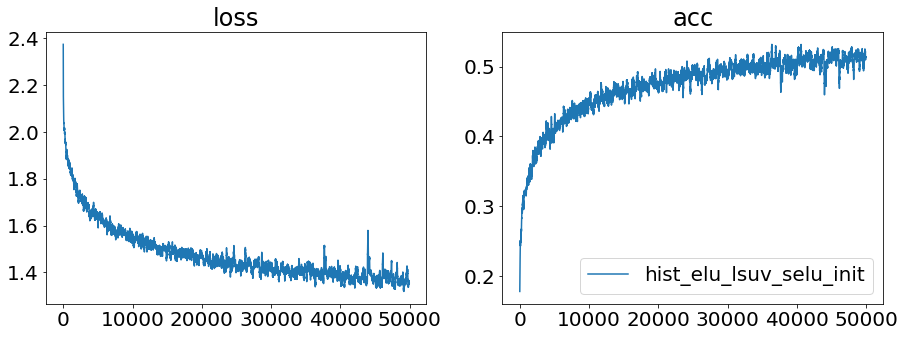

In [176]:
loss_history_tuple = (params, loss_history)
plot_loss_history(loss_history_tuple)

# Testing linear model 

100%|██████████| 50000/50000 [19:57<00:00, 41.75it/s]


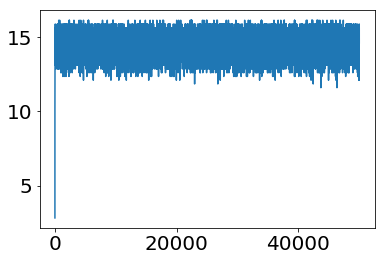

 9504/10000 [===========================>..] - ETA: 0sModel evaluation: [14.506285684204101, 0.10000000000000001]


In [177]:
params = {"activation": "linear"}
benchmark_model("hist@linear", **params)

In [279]:
name = "hist@linear"
fc_pred_history, loss_history, test_evaluation, params = get_history_data(name)


In [280]:
plot_interactive(fc_pred_history)

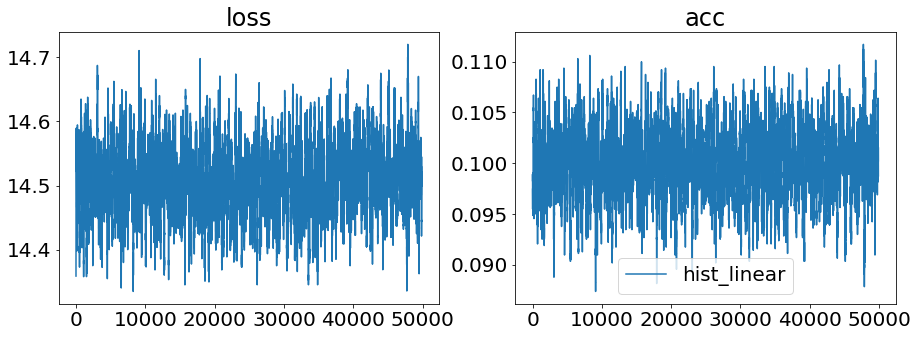

In [180]:
loss_history_tuple = (params, loss_history)
plot_loss_history(loss_history_tuple)

# Testing with prelu

100%|██████████| 50000/50000 [20:54<00:00, 39.87it/s]


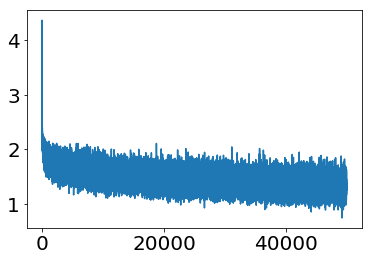

 9984/10000 [============================>.] - ETA: 0sModel evaluation: [1.3677815397262574, 0.52080000000000004]


In [182]:
params = {"activation": 'linear', "advanced_activation": prelu}
benchmark_model("hist@prelu", **params)

In [50]:
name = "hist@prelu"
fc_pred_history, loss_history, test_evaluation, params = get_history_data(name)
test_evaluation

[1.3677815397262574, 0.52080000000000004]

In [51]:
plot_interactive(fc_pred_history)

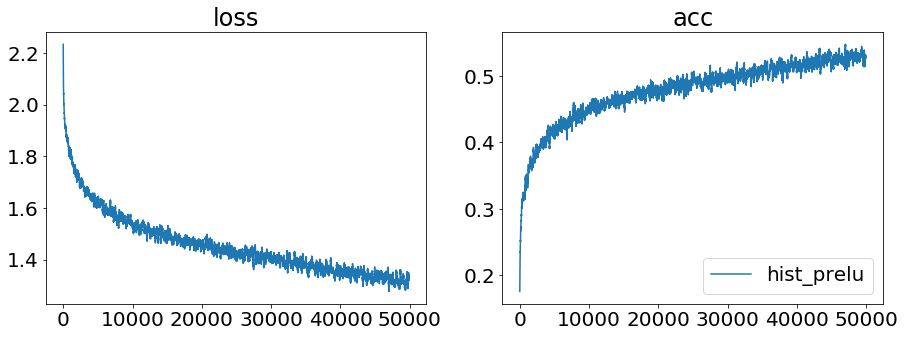

In [191]:
loss_history_tuple = (params, loss_history)
plot_loss_history(loss_history_tuple)

# Testing PRELU with SELU initialization

flatten_36
l1
LSUV initializing l1
0.291667
0.960492
1.00982
a1
l2
LSUV initializing l2
0.530754
0.928683
1.05993
0.982702
1.03596
1.02371
0.991786
a2
l3
LSUV initializing l3
0.435177
0.99543
a3
l4
LSUV initializing l4
0.490355


  0%|          | 0/50000 [00:00<?, ?it/s]

0.996261
a4
dense_35
dense_35 too small
activation_47
LSUV: total layers initialized 4


100%|██████████| 50000/50000 [20:53<00:00, 39.87it/s]


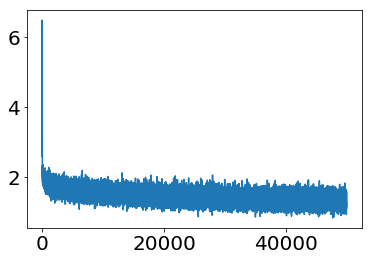

 9888/10000 [============================>.] - ETA: 0sModel evaluation: [1.3612837923049927, 0.52400000000000002]


In [186]:
params = {"activation": 'linear', "advanced_activation": prelu,
          "lsuv_init": True}
benchmark_model("hist@prelu@lsuv_init", **params)

In [26]:
name = "hist@prelu@lsuv_init"
fc_pred_history, loss_history, test_evaluation, params = get_history_data(name)

In [27]:
plot_interactive(fc_pred_history)

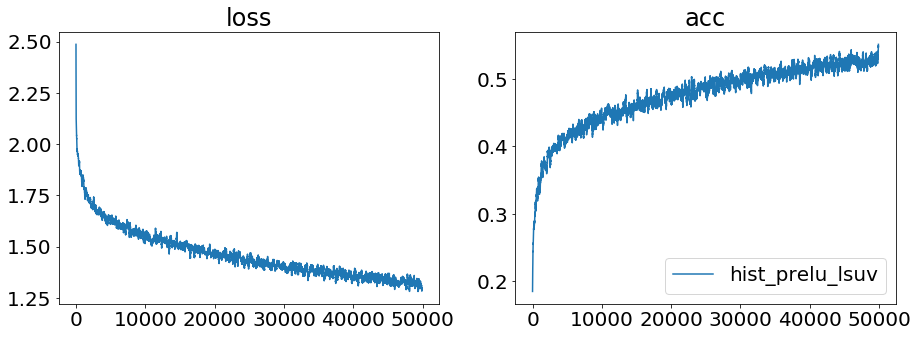

In [189]:
loss_history_tuple = (params, loss_history)
plot_loss_history(loss_history_tuple)

# Testing RELU with LSUV initialization and BN

flatten_37
l1
LSUV initializing l1
0.270379
1.02984
1.00401
a1
batch_normalization_1
l2
LSUV initializing l2
0.474974
0.95238
1.09231
0.924116
1.0496
1.00884
a2
batch_normalization_2
l3
LSUV initializing l3
0.579068
0.921407
1.02476
0.960463
1.08676
0.941241
1.02702
1.02098
0.937515
1.0167
1.05796
0.977268
a3
batch_normalization_3
l4
LSUV initializing l4
0.400515
1.11324
0.92878


  0%|          | 0/50000 [00:00<?, ?it/s]

1.00666
a4
batch_normalization_4
dense_36
dense_36 too small
activation_48
LSUV: total layers initialized 4


100%|██████████| 50000/50000 [23:14<00:00, 35.84it/s]


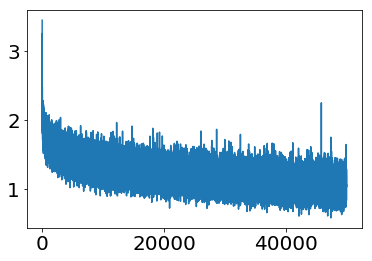

 9824/10000 [============================>.] - ETA: 0sModel evaluation: [1.2340685815811157, 0.56789999999999996]


In [190]:
params = {"activation": 'relu', "batch_norm": True,"lsuv_init": True}
benchmark_model("hist@relu@lsuv_init@bn", **params)

In [52]:
name = "hist@relu@lsuv_init@bn"
fc_pred_history, loss_history, test_evaluation, params = get_history_data(name)

In [53]:
plot_interactive(fc_pred_history)

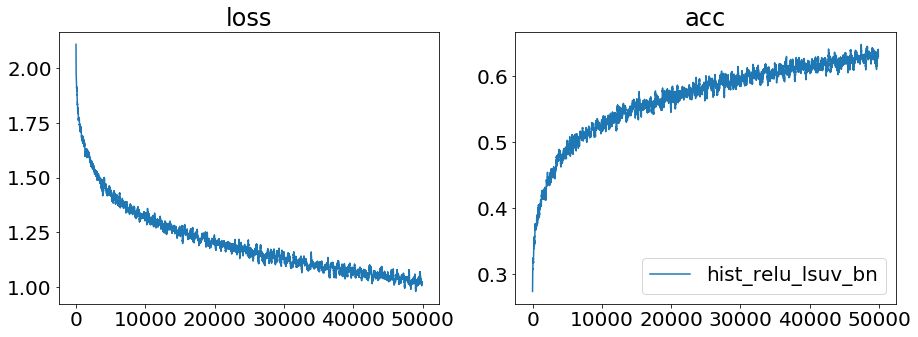

In [193]:
loss_history_tuple = (params, loss_history)
plot_loss_history(loss_history_tuple)

# Testing PRELU with LSUV initialization and BN

flatten_38
l1
LSUV initializing l1
0.274465
1.01589
1.01198
0.971627
1.02017
1.04941
0.945619
0.980546
1.08108
0.936945
0.979364
0.985149
a1
batch_normalization_5
l2
LSUV initializing l2
0.501457
0.983073
1.06146
0.914929
1.0226
1.0091
a2
batch_normalization_6
l3
LSUV initializing l3
0.529629
0.994437
a3
batch_normalization_7
l4
LSUV initializing l4
0.499197
0.981018
1.04312
1.02292
0.967241
1.01406
0.95931


  0%|          | 0/50000 [00:00<?, ?it/s]

1.00991
a4
batch_normalization_8
dense_37
dense_37 too small
activation_49
LSUV: total layers initialized 4


100%|██████████| 50000/50000 [24:05<00:00, 34.58it/s]


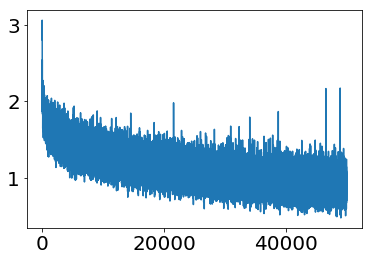

 9824/10000 [============================>.] - ETA: 0sModel evaluation: [1.3031312900543213, 0.56879999999999997]


In [194]:
params = {"activation": 'linear', "advanced_activation": prelu,
          "lsuv_init": True, "batch_norm": True}
benchmark_model("hist@prelu@lsuv_init@bn", **params)

In [287]:
name = "hist@prelu@lsuv_init@bn"
fc_pred_history, loss_history, test_evaluation, params = get_history_data(name)

In [288]:
plot_interactive(fc_pred_history)

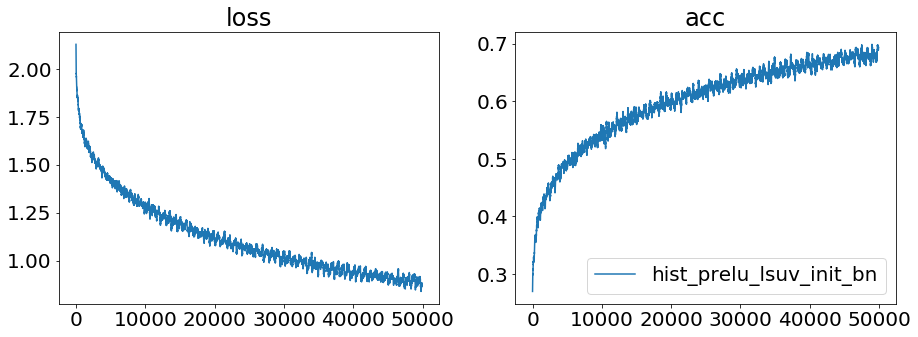

In [197]:
loss_history_tuple = (params, loss_history)
plot_loss_history(loss_history_tuple)

# Testing SELU with regularization and BN

with selu Reg
with selu Reg
with selu Reg
with selu Reg

100%|██████████| 50000/50000 [24:47<00:00, 33.62it/s]


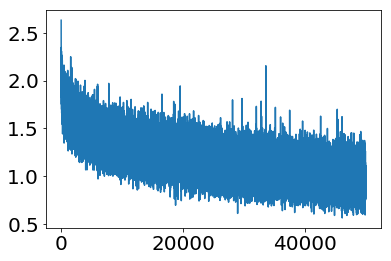

 9568/10000 [===========================>..] - ETA: 0sModel evaluation: [1.2226383369445801, 0.59650000000000003]


In [198]:
params = {"activation": selu, "selu_init": True, "selu_reg": True, "batch_norm": True}
benchmark_model("hist@selu@selu_init@bn@selu_reg", **params)

In [54]:
name = "hist@selu@selu_init@bn@selu_reg"
fc_pred_history, loss_history, test_evaluation, params = get_history_data(name)

In [55]:
plot_interactive(fc_pred_history)

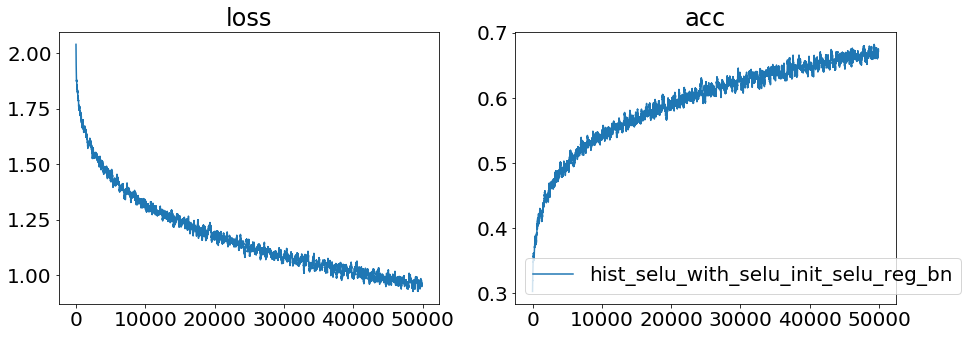

In [201]:
loss_history_tuple = (params, loss_history)
plot_loss_history(loss_history_tuple)

# Testing SELU with BN

100%|██████████| 50000/50000 [23:42<00:00, 35.15it/s]


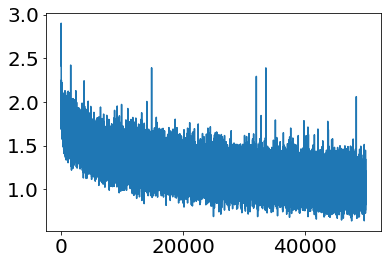

 9696/10000 [============================>.] - ETA: 0sModel evaluation: [1.2043347185134887, 0.58040000000000003]


In [202]:
params = {"activation": selu, "selu_init": True, "batch_norm": True}
benchmark_model("hist@selu@selu_init@bn", **params)

In [32]:
name = "hist@selu@selu_init@bn"
fc_pred_history, loss_history, test_evaluation, params = get_history_data(name)

In [33]:
plot_interactive(fc_pred_history)

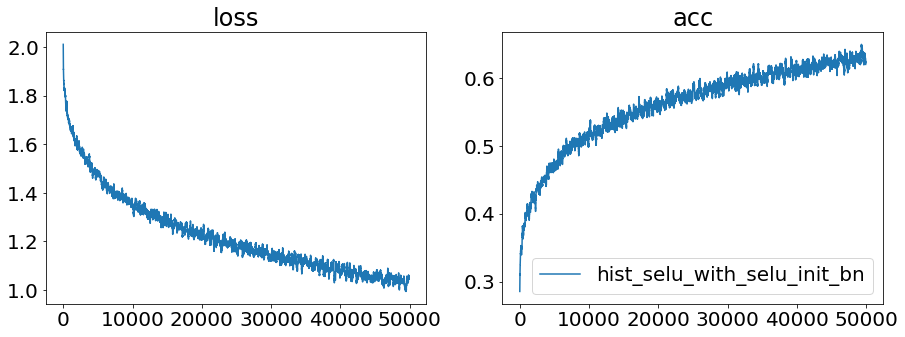

In [205]:
loss_history_tuple = (params, loss_history)
plot_loss_history(loss_history_tuple)

# Testing PRELU with BN and SELU regularization

with selu Reg
with selu Reg
with selu Reg
with selu Reg
flatten_41
l1
LSUV initializing l1
0.284695
0.931616
1.04175
0.992227
a1
batch_normalization_17
l2
LSUV initializing l2
0.486637
0.988165
1.00888
a2
batch_normalization_18
l3
LSUV initializing l3
0.459569
1.03231
0.973692
1.01705
1.02117
0.995144
a3
batch_normalization_19
l4
LSUV initializing l4
0.511268
0.95962


  0%|          | 0/50000 [00:00<?, ?it/s]

1.00481
a4
batch_normalization_20
dense_40
dense_40 too small
activation_52
LSUV: total layers initialized 4


100%|██████████| 50000/50000 [25:31<00:00, 32.86it/s]


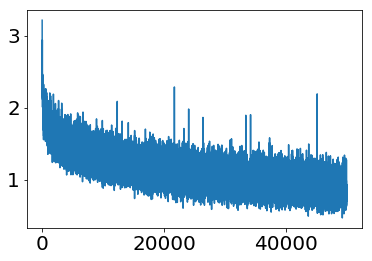

 9600/10000 [===========================>..] - ETA: 0sModel evaluation: [1.2240707973480225, 0.60429999999999995]


In [206]:
params = {"activation": 'linear', "advanced_activation": prelu,
          "lsuv_init": True, "batch_norm": True, "selu_reg": True}
benchmark_model("hist@prelu@lsuv_init@bn@selu_reg", **params)

In [56]:
name = "hist@prelu@lsuv_init@bn@selu_reg"
fc_pred_history, loss_history, test_evaluation, params = get_history_data(name)


In [57]:
plot_interactive(fc_pred_history)

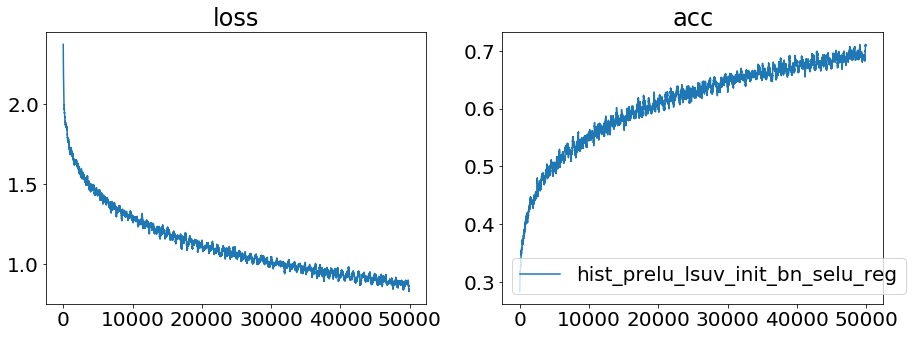

In [209]:
loss_history_tuple = (params, loss_history)
plot_loss_history(loss_history_tuple)

# Testing PRELU with BN and SELU regularization and batch regularization

with batch_reg
with selu Reg
with batch_reg
with selu Reg
with batch_reg
with selu Reg
with batch_reg
with selu Reg
flatten_28
l1
LSUV initializing l1
0.301041
0.970052
1.00299
a1
batch_normalization_5
l2
LSUV initializing l2
0.602388
0.883287
1.0527
1.0019
a2
batch_normalization_6
l3
LSUV initializing l3
0.502942
0.955329
1.04131
0.978214
0.964799
1.04052
0.996002
a3
batch_normalization_7
l4
LSUV initializing l4
0.499116
1.01557


  0%|          | 0/50000 [00:00<?, ?it/s]

1.00124
a4
batch_normalization_8
dense_25
dense_25 too small
activation_25
LSUV: total layers initialized 4


100%|██████████| 50000/50000 [33:04<00:00, 25.33it/s]


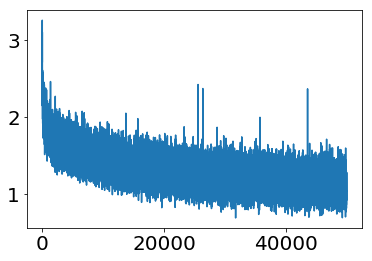

 9920/10000 [============================>.] - ETA: 0sModel evaluation: [1.4343519161224365, 0.56599999999999995]


In [77]:
params = {"activation": 'linear', "advanced_activation": prelu,
          "lsuv_init": True, "batch_norm": True, "selu_reg": True, "batch_reg": True}
benchmark_model("hist@prelu@lsuv_init@bn@selu_reg@batch_reg", **params)

In [36]:
name = "hist@prelu@lsuv_init@bn@selu_reg@batch_reg"
fc_pred_history, loss_history, test_evaluation, params = get_history_data(name)


In [37]:
plot_interactive(fc_pred_history)

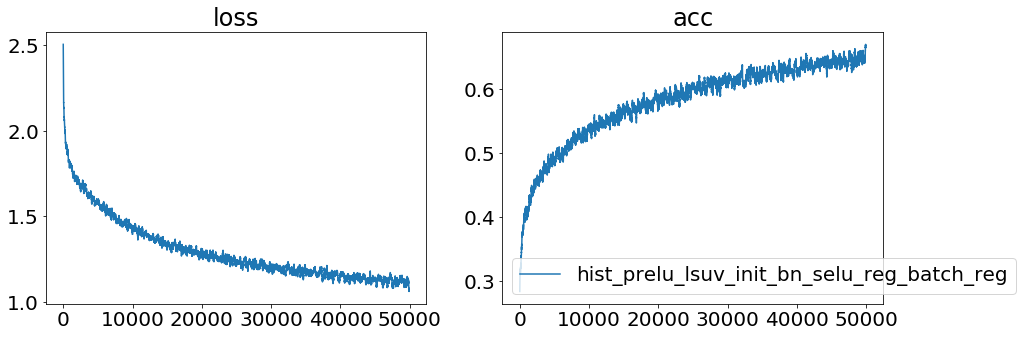

In [80]:
loss_history_tuple = (params, loss_history)
plot_loss_history(loss_history_tuple)

# Testing PRELU with BN and SELU regularization and lets dense

with selu Reg
with selu Reg
with selu Reg
with selu Reg


  0%|          | 0/50000 [00:00<?, ?it/s]

flatten_37
l1
a1
batch_normalization_9
l2
a2
batch_normalization_10
l3
a3
batch_normalization_11
l4
a4
batch_normalization_12
dense_31
dense_31 too small
activation_31
LSUV: total layers initialized 0


100%|██████████| 50000/50000 [32:52<00:00, 25.35it/s]


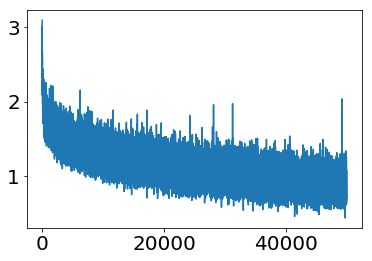

 9696/10000 [============================>.] - ETA: 0sModel evaluation: [1.2123630483627319, 0.60099999999999998]


In [106]:
params = {"activation": 'linear', "advanced_activation": prelu,
          "lsuv_init": True, "batch_norm": True, "selu_reg": True, "lets_dense": True}
benchmark_model("hist@prelu@lsuv_init@bn@selu_reg@lets_dense", **params)

In [38]:
name = "hist@prelu@lsuv_init@bn@selu_reg@lets_dense"
fc_pred_history, loss_history, test_evaluation, params = get_history_data(name)


In [39]:
plot_interactive(fc_pred_history)

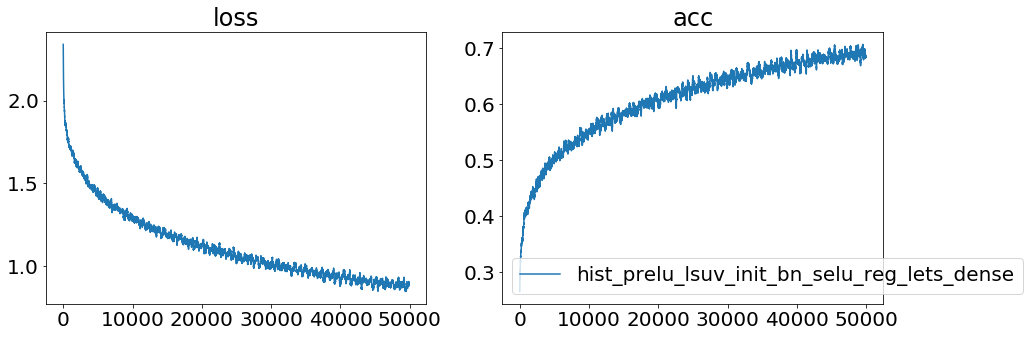

In [113]:
loss_history_tuple = (params, loss_history)
plot_loss_history(loss_history_tuple)

# Testing SELU with regularization and batch regularization

  0%|          | 0/50000 [00:00<?, ?it/s]

with batch_reg
with selu Reg
with batch_reg
with selu Reg
with batch_reg
with selu Reg
with batch_reg
with selu Reg


100%|██████████| 50000/50000 [30:45<00:00, 27.09it/s]


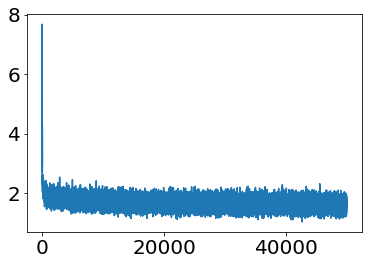

 9568/10000 [===========================>..] - ETA: 0sModel evaluation: [1.5959891431808471, 0.50800000000000001]


In [119]:
params = {"activation": selu, "selu_init": True, "selu_reg": True, "batch_reg": True}
benchmark_model("hist@selu@selu_init@selu_reg@batch_reg", **params)

In [40]:
name = "hist@selu@selu_init@selu_reg@batch_reg"
fc_pred_history, loss_history, test_evaluation, params = get_history_data(name)

In [41]:
plot_interactive(fc_pred_history)

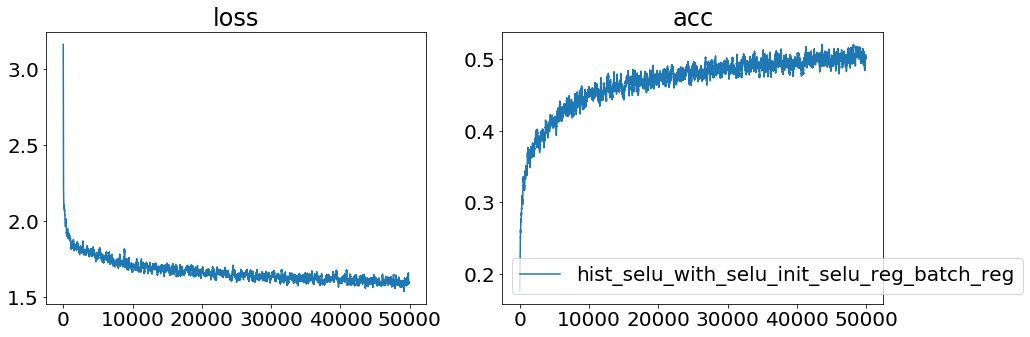

In [124]:
loss_history_tuple = (params, loss_history)
plot_loss_history(loss_history_tuple)

# Plot summary

In [64]:
from glob import glob
import os

In [226]:
prefix = "cifar10_dense"
history_files = glob(f"activations_history_data/{prefix}*.pkl")
history_files = list(filter(lambda x: "@" in x and "test" not in x, history_files))
history_files

['activations_history_data/cifar10_dense_hist@selu@lsuv_init.pkl',
 'activations_history_data/cifar10_dense_hist@prelu@lsuv_init@bn@selu_reg@batch_reg.pkl',
 'activations_history_data/cifar10_dense_hist@selu@selu_init@selu_reg.pkl',
 'activations_history_data/cifar10_dense_hist@prelu.pkl',
 'activations_history_data/cifar10_dense_hist@prelu@lsuv_init@bn.pkl',
 'activations_history_data/cifar10_dense_hist@linear.pkl',
 'activations_history_data/cifar10_dense_hist@prelu@lsuv_init@bn@selu_reg.pkl',
 'activations_history_data/cifar10_dense_hist@prelu@lsuv_init@bn@selu_reg@lets_dense.pkl',
 'activations_history_data/cifar10_dense_hist@relu@lsuv_init@bn.pkl',
 'activations_history_data/cifar10_dense_hist@relu.pkl',
 'activations_history_data/cifar10_dense_hist@selu@lsuv_selu_init.pkl',
 'activations_history_data/cifar10_dense_hist@selu@selu_init@bn.pkl',
 'activations_history_data/cifar10_dense_hist@selu@selu_init@bn@selu_reg.pkl',
 'activations_history_data/cifar10_dense_hist@selu.pkl',
 'a

In [237]:
features = []
for f in history_files:
    features += f.split(".pkl")[0].split("@")[1:]

features_list = list(set(features))
features_list

['prelu',
 'selu',
 'lsuv_init',
 'bn',
 'linear',
 'lsuv_selu_init',
 'batch_reg',
 'selu_init',
 'lets_dense',
 'relu',
 'selu_reg',
 'elu']

In [255]:
import pandas as pd

df = pd.DataFrame(columns=["name", "test_acc", "train_acc", "test_loss", "train_loss"])

loss_history_tuple_list = []
for i, hist_file in tqdm(enumerate(history_files)):
    name = os.path.split(hist_file)[-1][len(prefix)+1:-4]
    fc_pred_history, loss_history, test_evaluation, params = get_history_data(name)    
    loss_history_tuple_list.append((params, loss_history))
    
    # table
    mean_acc = np.array(loss_history)[-50:, 1].mean()
    mean_loss = np.array(loss_history)[-50:, 0].mean()
    
    row = [name, 
           f"{test_evaluation[1]:5.3f}", 
           f"{mean_acc:5.3f}", 
           f"{test_evaluation[0]:5.3f}", 
           f"{mean_loss:5.3f}"]
    df.loc[i] = row

17it [00:02,  7.55it/s]


In [264]:
new_df = df.copy()

for feat in features_list:
    new_df[feat] = new_df.name.apply(lambda x: "X" if feat in x.split("@") else "-")
new_df = new_df.drop("name", axis=1)
new_df.sort_values(by="test_acc", ascending=False)

# new_df.sort_values(by="train_acc", ascending=True)

,test_acc,train_acc,test_loss,train_loss,prelu,selu,lsuv_init,bn,linear,lsuv_selu_init,batch_reg,selu_init,lets_dense,relu,selu_reg,elu
6,0.604,0.713,1.224,0.821,X,-,X,X,-,-,-,-,-,-,X,-
7,0.601,0.684,1.212,0.883,X,-,X,X,-,-,-,-,X,-,X,-
12,0.597,0.674,1.223,0.957,-,X,-,X,-,-,-,X,-,-,X,-
11,0.580,0.618,1.204,1.042,-,X,-,X,-,-,-,X,-,-,-,-
4,0.569,0.696,1.303,0.862,X,-,X,X,-,-,-,-,-,-,-,-
8,0.568,0.626,1.234,1.047,-,-,X,X,-,-,-,-,-,X,-,-
1,0.566,0.673,1.434,1.068,X,-,X,X,-,-,X,-,-,-,X,-
2,0.565,0.548,1.316,1.368,-,X,-,-,-,-,-,X,-,-,X,-
0,0.528,0.498,1.358,1.403,-,X,X,-,-,-,-,-,-,-,-,-
16,0.524,0.555,1.361,1.289,X,-,X,-,-,-,-,-,-,-,-,-


In [260]:
def plot_loss_history_raport(loss_history_tuple, start_step=0, fontsize=8, min_acc=0.0, max_acc=1):
    
    def running_mean(x, N=100):
        cumsum = np.cumsum(np.insert(x, 0, 0)) 
        return (cumsum[N:] - cumsum[:-N]) / N 
    
    plt.figure(figsize=(20, 15))
    plt.subplot(211)
    plt.title("loss")
    for i in range(len(loss_history_tuple)):
        params, loss_history = loss_history_tuple[i]        
        mean_acc = np.array(loss_history)[-20:, 1].mean()
        if mean_acc > min_acc and mean_acc < max_acc:
            print(params['name'], mean_acc)
            plt.plot(running_mean(np.array(loss_history)[start_step:, 0]), label=params['name'])
    
    plt.ylim([0.8, 2])
    plt.legend(fontsize=fontsize, loc=2)
    plt.subplot(212)
    plt.title("acc")
    for i in range(len(loss_history_tuple)):
        params, loss_history = loss_history_tuple[i]    
        mean_acc = np.array(loss_history)[-20:, 1].mean()
        if mean_acc > min_acc and mean_acc < max_acc:
            plt.plot(running_mean(np.array(loss_history)[start_step:, 1]), label=params['name'])
    
    plt.legend(fontsize=fontsize, loc=2)
    plt.show()  

hist_selu_lsuv_init 0.503125
hist_prelu_lsuv_init_bn_selu_reg_batch_reg 0.663281
hist_selu_with_selu_reg 0.545313
hist_prelu 0.517187
hist_prelu_lsuv_init_bn 0.690625
hist_linear 0.0867188
hist_prelu_lsuv_init_bn_selu_reg 0.695312
hist_prelu_lsuv_init_bn_selu_reg_lets_dense 0.686719
hist_relu_lsuv_bn 0.614062
hist_relu 0.482031
hist_selu_lsuv_selu_init 0.479688
hist_selu_with_selu_init_bn 0.6125
hist_selu_with_selu_init_selu_reg_bn 0.679688
hist_selu 0.441406
hist_elu_lsuv_selu_init 0.521875
hist_selu_with_selu_init_selu_reg_batch_reg 0.485938
hist_prelu_lsuv 0.558594


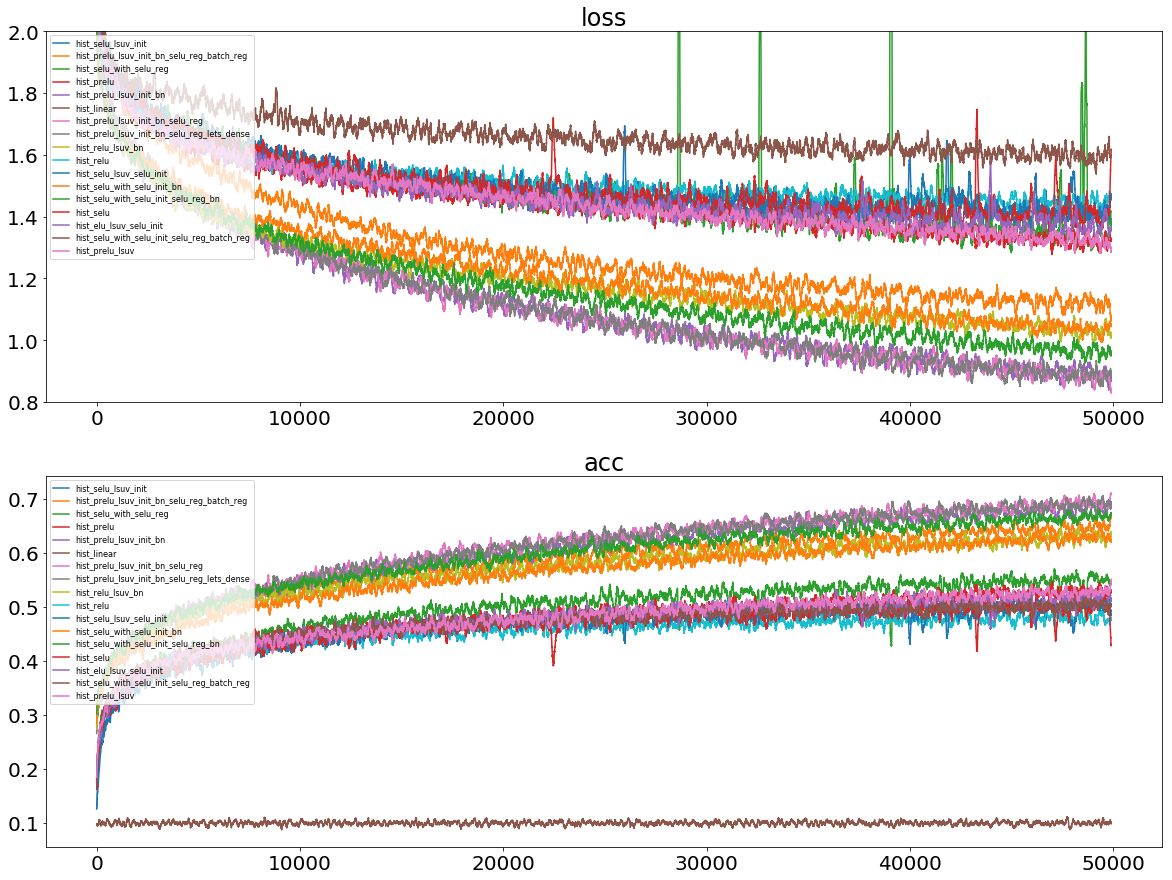

In [261]:
plot_loss_history_raport(loss_history_tuple_list)

hist_selu_lsuv_init 0.503125
hist_prelu_lsuv_init_bn_selu_reg_batch_reg 0.663281
hist_selu_with_selu_reg 0.545313
hist_prelu 0.517187
hist_prelu_lsuv_init_bn 0.690625
hist_linear 0.0867188
hist_prelu_lsuv_init_bn_selu_reg 0.695312
hist_prelu_lsuv_init_bn_selu_reg_lets_dense 0.686719
hist_relu_lsuv_bn 0.614062
hist_relu 0.482031
hist_selu_lsuv_selu_init 0.479688
hist_selu_with_selu_init_bn 0.6125
hist_selu_with_selu_init_selu_reg_bn 0.679688
hist_selu 0.441406
hist_elu_lsuv_selu_init 0.521875
hist_selu_with_selu_init_selu_reg_batch_reg 0.485938
hist_prelu_lsuv 0.558594


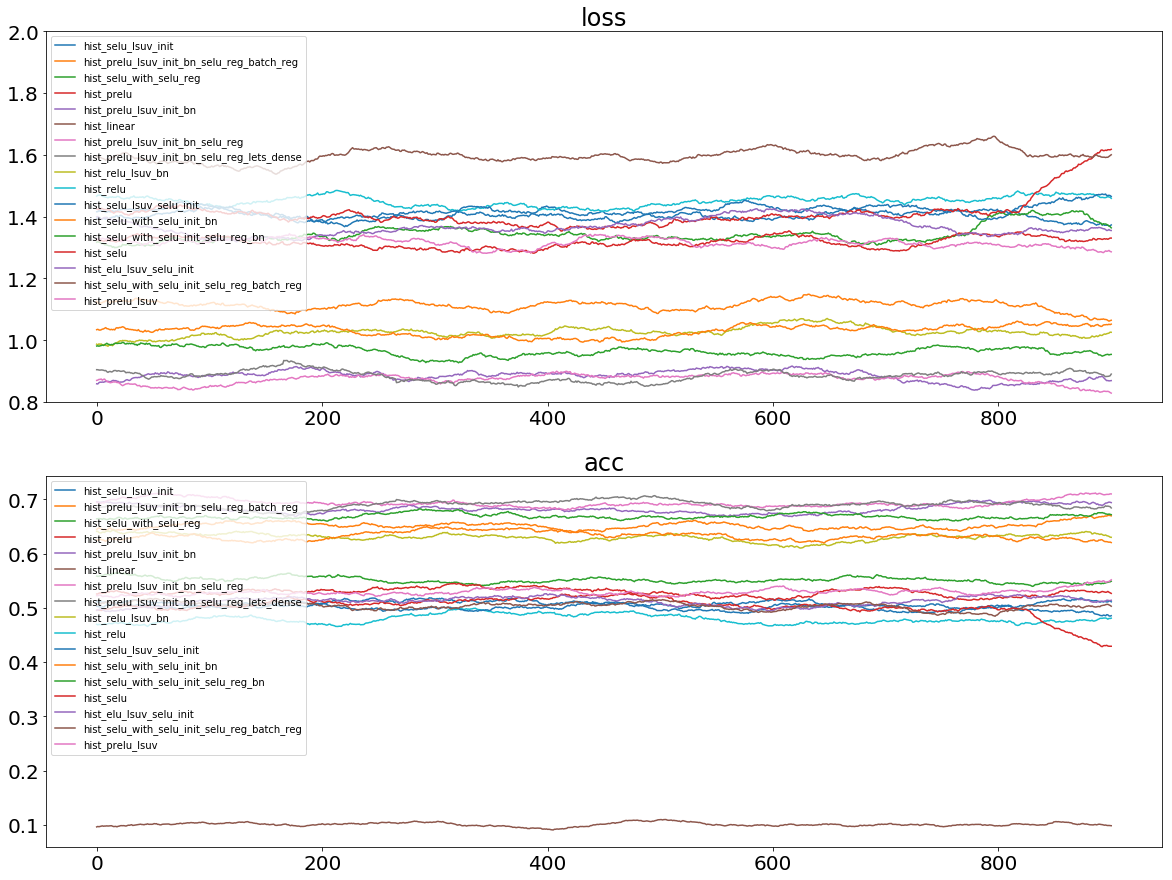

In [262]:
plot_loss_history_raport(loss_history_tuple_list, start_step=-1000, fontsize=10)

hist_prelu_lsuv_init_bn_selu_reg_batch_reg 0.663281
hist_prelu_lsuv_init_bn 0.690625
hist_prelu_lsuv_init_bn_selu_reg 0.695312
hist_prelu_lsuv_init_bn_selu_reg_lets_dense 0.686719
hist_relu_lsuv_bn 0.614062
hist_selu_with_selu_init_bn 0.6125
hist_selu_with_selu_init_selu_reg_bn 0.679688


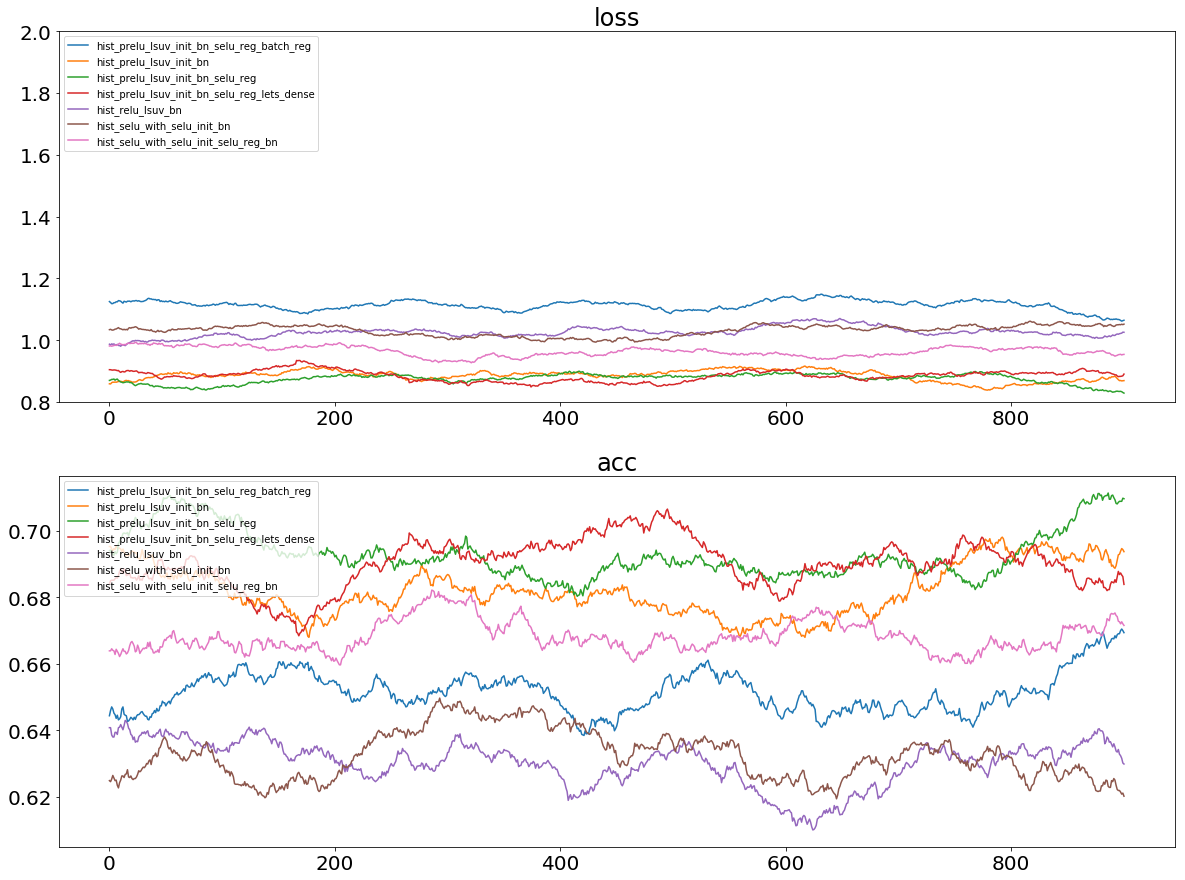

In [263]:
plot_loss_history_raport(loss_history_tuple_list, start_step=-1000, fontsize=10, min_acc=0.57)

hist_selu_lsuv_init 0.503125
hist_elu_lsuv_selu_init 0.521875
hist_relu 0.482031
hist_selu_with_selu_init_selu_reg_batch_reg 0.485938
hist_prelu_lsuv 0.558594
hist_prelu_lsuv_init_batch_reg 0.508594
hist_selu_lsuv_selu_init 0.479688
hist_selu_with_selu_reg 0.545313
hist_selu 0.441406
hist_prelu 0.517187


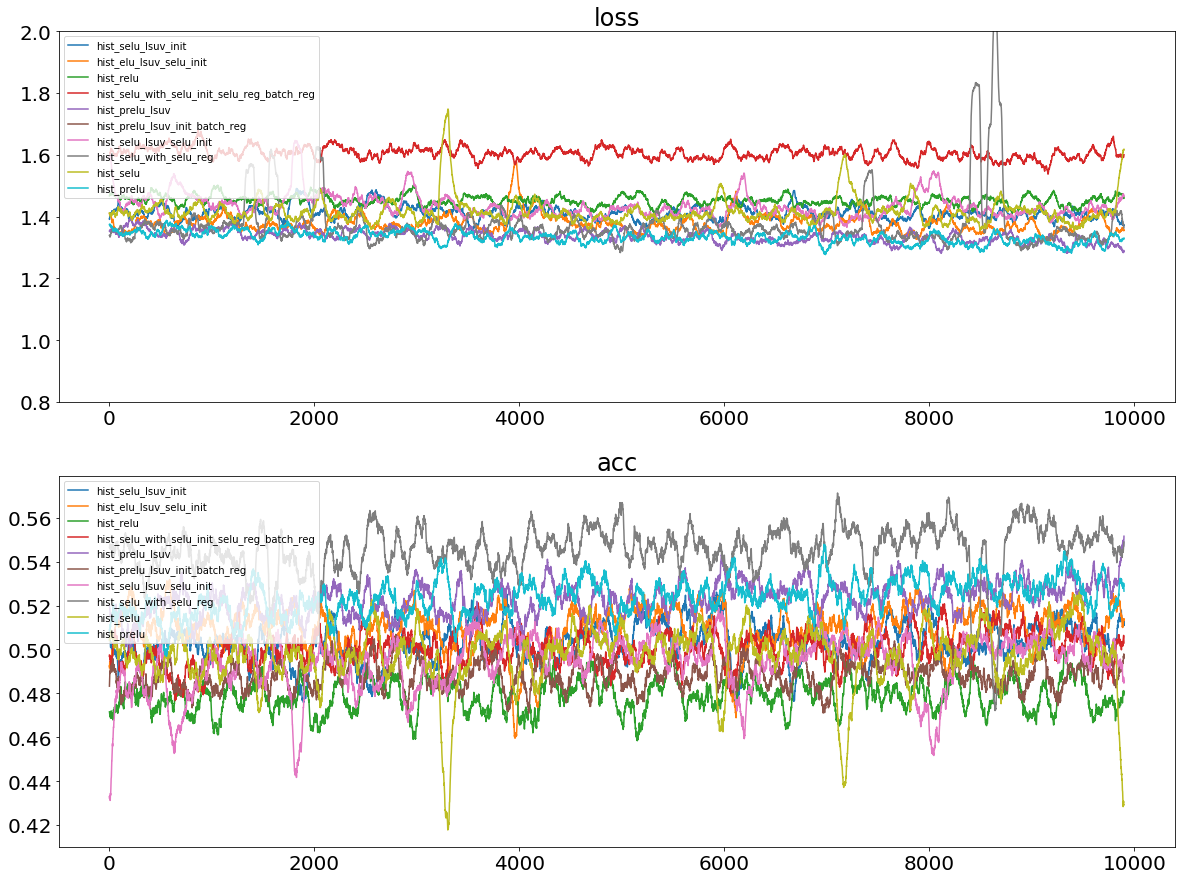

In [134]:
plot_loss_history_raport(loss_history_tuple_list, start_step=-10000, fontsize=10, max_acc=0.57)